# Modflow-API example

In this example we'll explore Modflow-API support by working with the Green Valley Example Model (Prudic et al., 2004; Niswonger et al., 2006).

The goal of this Notebook is to 1) get familiar with the `modflowapi` python package and MF6-API features, and 2) to show how to change boundary conditions in a model with the `modflowapi`.

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import modflowapi
from pathlib import Path
from flopy.plot import styles

import green_valley as gv


### We'll start by building a slightly modified version of the Green Valley Model that simulates the steady state and the pumping stress period.

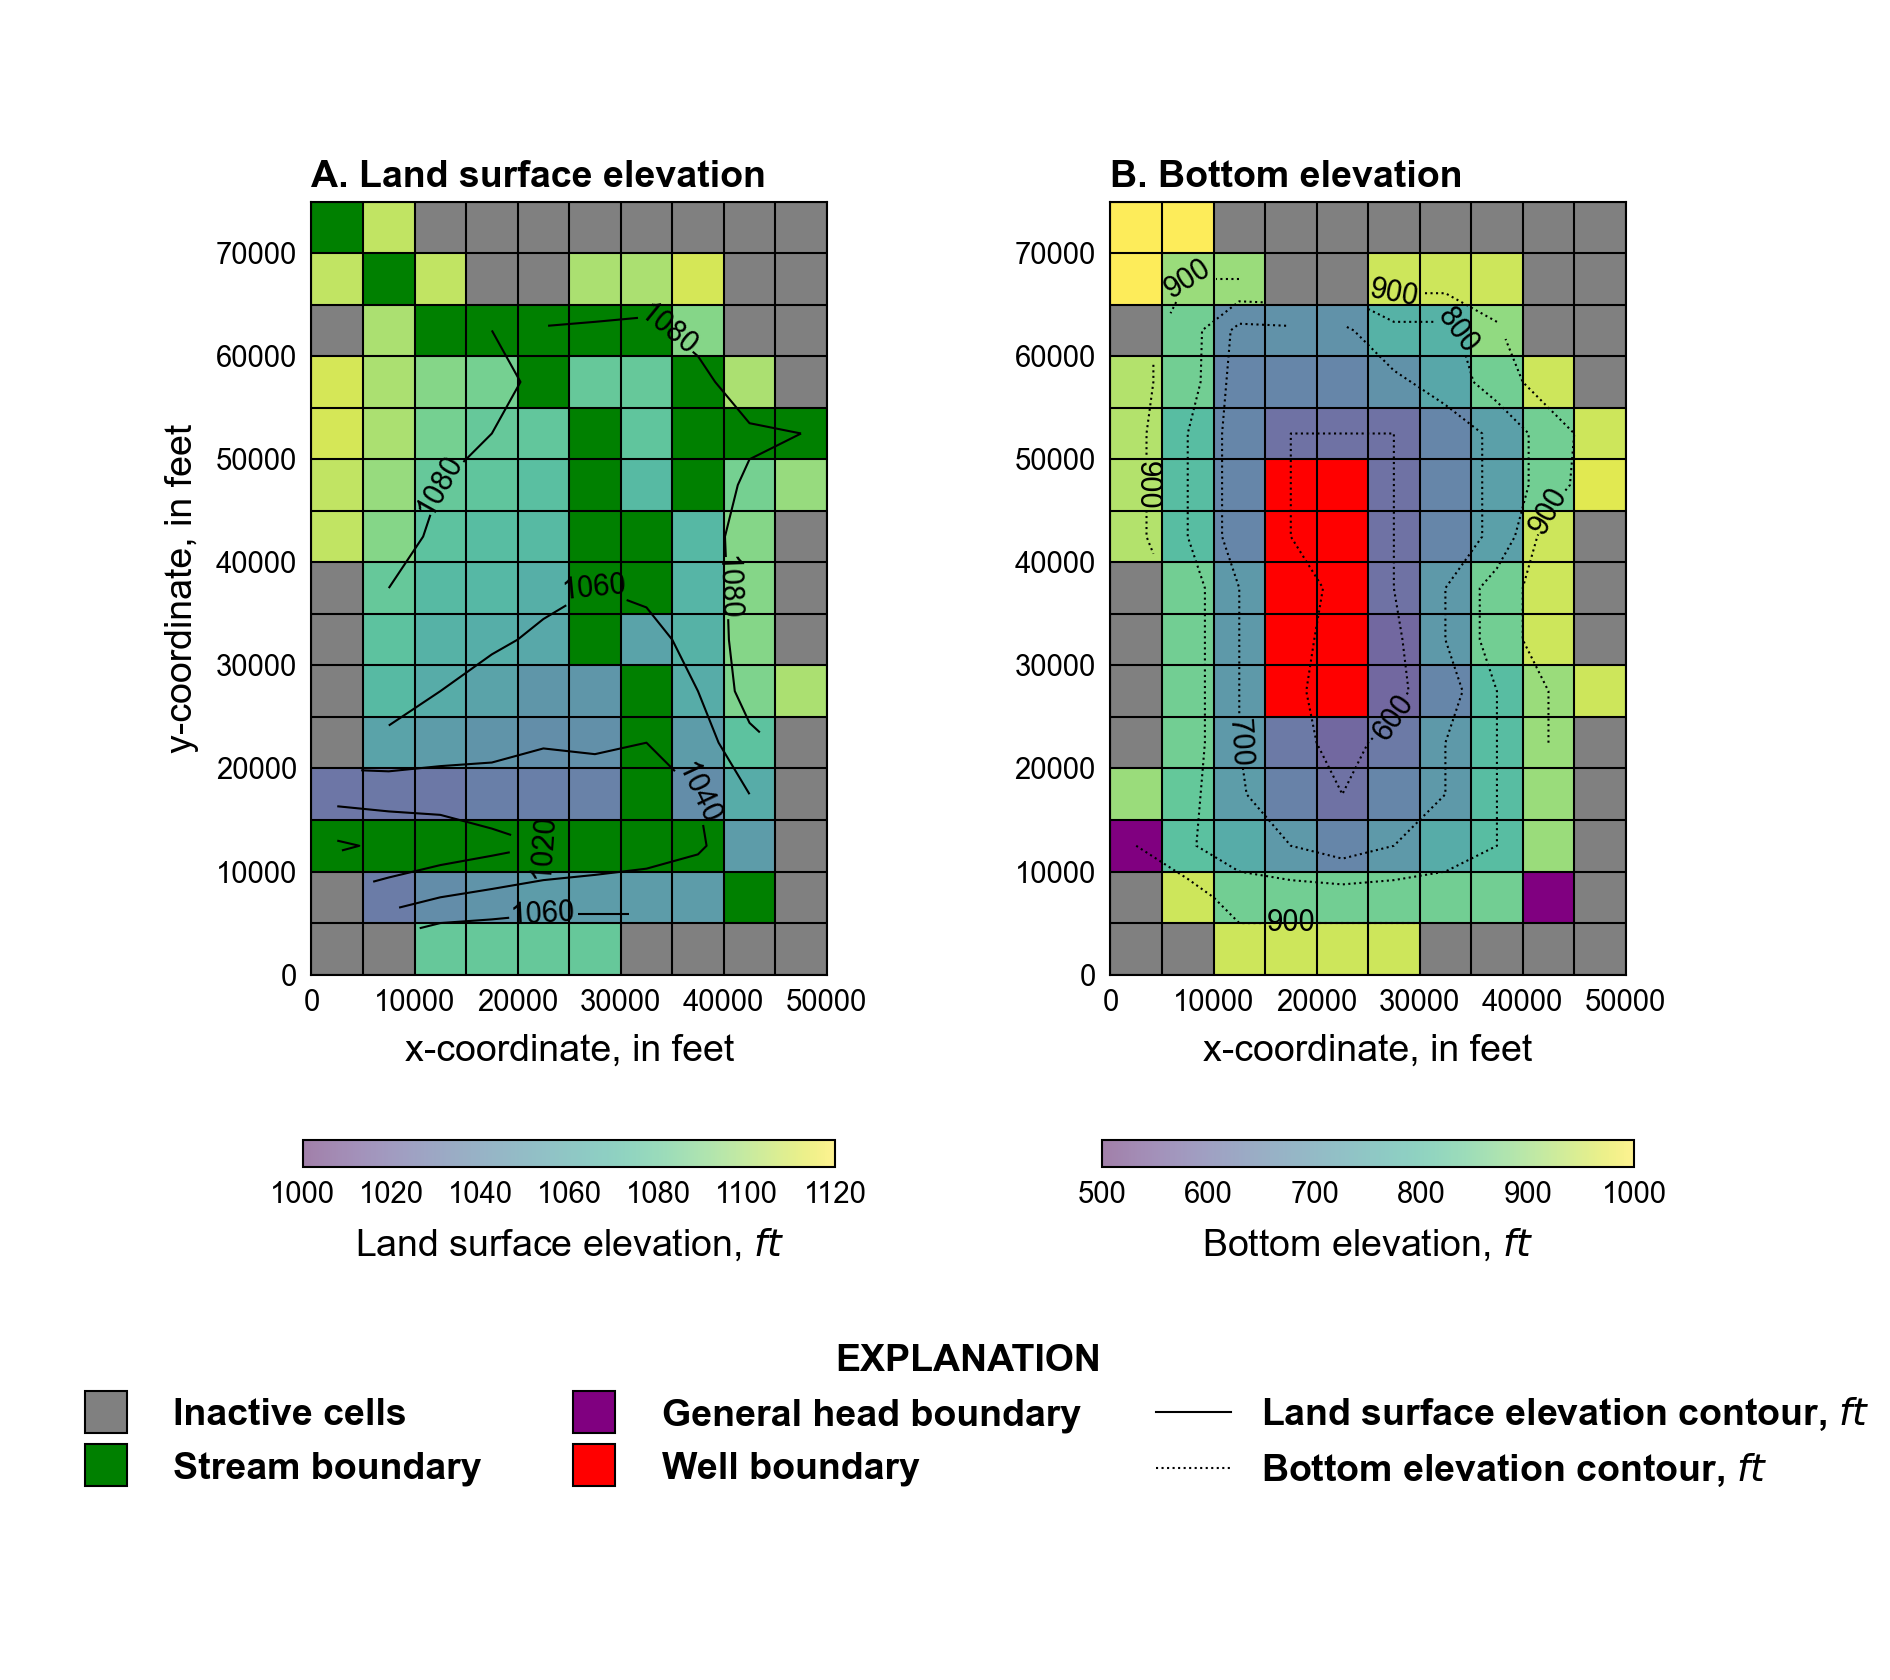

### Our scenario
Green Valley Water wants to begin pumping 10 public supply wells near Green Creek at the rate of 10 cu-ft/s. However, Green Creek provides import spawing habitat for a population of California Golden Trout that primarily lives in Blue River. It's been noted that stream levels dropping to less than 5" or about 0.42 ft could have negative impacts on the trout population. Our task is to find a sustainable long term pumping rates while maintaining in stream flows. 

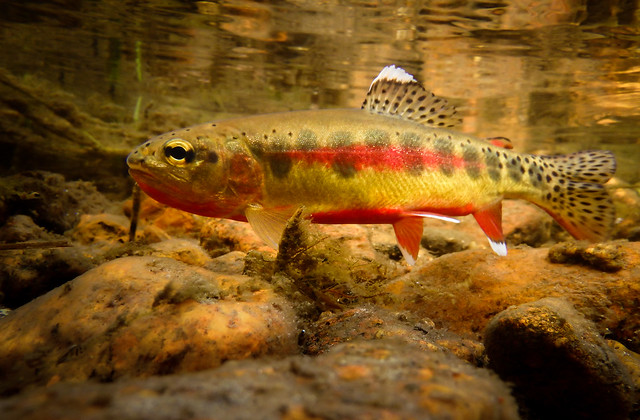

We've already built the initial model with Green Valley Water's desired pumping rates for an initial evaluation. 

#### Let's set up our model

We will use a pre-made function that builds our base model input files. If you're interesting in the process of building the model, take a look at `green_valley.py`

In [2]:
sim_ws = Path("../data/green_valley")
model_name = "green_valley"
sim = gv.build_models()
gwf = sim.get_model()

Now that we have our model, let's visualize it quickly:

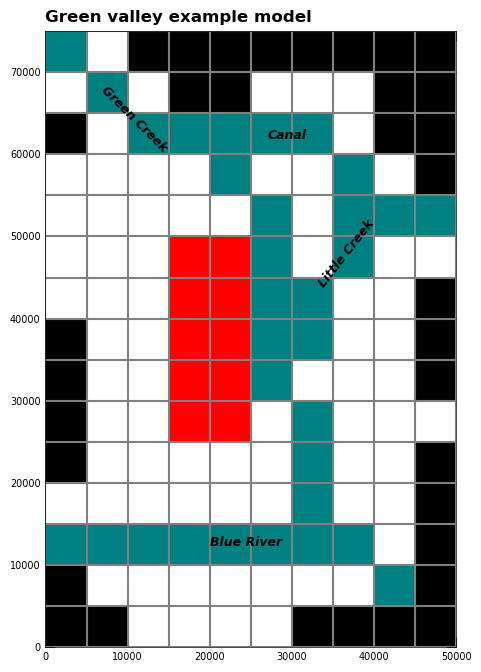

In [3]:
with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(6, 8))

    pmv = flopy.plot.PlotMapView(gwf,)
    pmv.plot_inactive()
    pmv.plot_grid()
    pmv.plot_bc("SFR")
    pmv.plot_bc("WEL", plotAll=True)
    # add a heading to the plot
    styles.heading(
        ax=ax, heading="Green valley example model", fontsize=12
    )
    # annotate the rivers in the plot
    styles.add_text(
        ax, text="Green Creek", x=0.13, y=0.80, bold=True, rotation=-45, fontsize=9
    )
    styles.add_text(
        ax, text="Canal", x=0.54, y=0.82, bold=True, fontsize=9
    )
    styles.add_text(
        ax, text="Little Creek", x=0.66, y=0.58, bold=True, rotation=52, fontsize=9
    )
    styles.add_text(
        ax, text="Blue River", x=0.40, y=0.16, bold=True, fontsize=9
    );

Let's write the simulation inputs and run the model to look at our base case

In [4]:
sim.write_simulation()
sim.run_simulation();

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model green_valley...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 2 based on size of stress_period_data
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 10 based on size of stress_period_data
    writing package rcha_0...
    writing package evta_0...
    writing package sfr_0...
    writing package obs_0...
    writing package oc...
FloPy is using the following executable to run the model: ..\..\..\..\..\AppData\Local\flopy\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled

And to look at the initial results

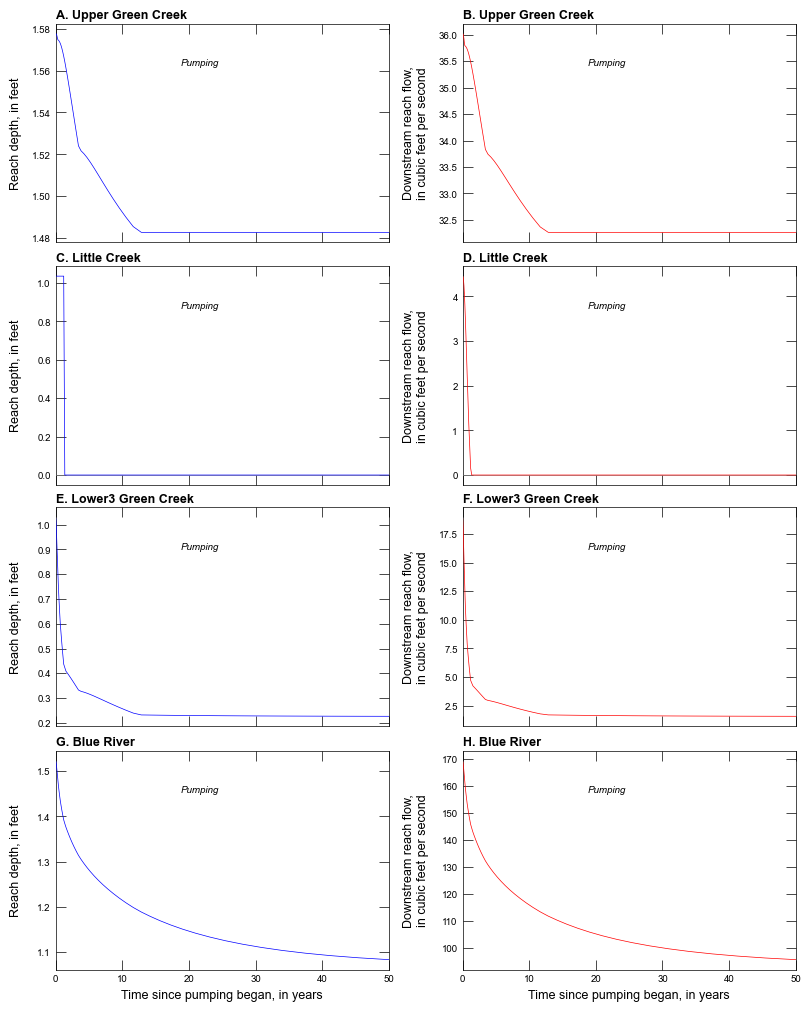

In [5]:
gv.plot_sfr_results(gwf)

Oh no. Pumping at 10 cu-ft/s from 10 wells would reduce Green Creek's water levels below the required water levels.

Now let's load up the observation output to see exactly how long it took for Green Creek water levels to decline past the required threshold of 0.42 ft. 

In [6]:
obs = gwf.sfr.output.obs()
df = obs.get_dataframe(start_datetime=dt.datetime(2024, 6, 1), timeunit="s")
df.head()

,totim,R01_STAGE,R02_STAGE,R03_STAGE,R04_STAGE,R01_FLOW,R02_FLOW,R03_FLOW,R04_FLOW
2024-06-01 00:00:00.000000,0.000000e+00,1078.985710,1061.581,1026.938536,993.398198,-36.023592,-4.453959,-18.963507,-169.415864
2024-06-16 16:34:33.543892,1.355674e+06,1078.985652,1061.581,1026.924784,993.395890,-36.019027,-4.445658,-18.548148,-168.989651
2024-07-03 22:48:34.442173,2.846914e+06,1078.985460,1061.581,1026.898299,993.391190,-36.003868,-4.415830,-17.758700,-168.122471
2024-07-22 22:27:59.430282,4.487279e+06,1078.985055,1061.581,1026.859635,993.384075,-35.972159,-4.349762,-16.631285,-166.812123
2024-08-12 19:41:20.917202,6.291681e+06,1078.984377,1061.581,1026.815183,993.375493,-35.919486,-4.234304,-15.372294,-165.236016


**Of note:** R01 is Upper Green Creek (reach 4), R02 is Little Creek (Reach 15), R03 is Lower Green Creek (Reach 27), and R04 is Blue River (Reach 35). We can store this information for later in a dictionary

In [7]:
reach_info = {
    3: ("R01", "Upper Green Creek"), 
    14: ("R02", "Little Creek"),
    26: ("R03", "Lower Green Creek"),
    35: ("R04", "Blue River")
}


And to calculate the river depth we need to subtract the top of the river bed from the stage

In [8]:
rtops = gwf.sfr.packagedata.array["rtp"]
for rno, (rtag, name) in reach_info.items():
    new_col = f"{rtag}_depth"
    stage_col = f"{rtag}_STAGE"
    rtop = rtops[rno]
    df[new_col] = df[stage_col] - rtop

df.head()

,totim,R01_STAGE,R02_STAGE,R03_STAGE,R04_STAGE,R01_FLOW,R02_FLOW,R03_FLOW,R04_FLOW,R01_depth,R02_depth,R03_depth,R04_depth
2024-06-01 00:00:00.000000,0.000000e+00,1078.985710,1061.581,1026.938536,993.398198,-36.023592,-4.453959,-18.963507,-169.415864,1.577710,1.036,1.029536,1.523198
2024-06-16 16:34:33.543892,1.355674e+06,1078.985652,1061.581,1026.924784,993.395890,-36.019027,-4.445658,-18.548148,-168.989651,1.577652,1.036,1.015784,1.520890
2024-07-03 22:48:34.442173,2.846914e+06,1078.985460,1061.581,1026.898299,993.391190,-36.003868,-4.415830,-17.758700,-168.122471,1.577460,1.036,0.989299,1.516190
2024-07-22 22:27:59.430282,4.487279e+06,1078.985055,1061.581,1026.859635,993.384075,-35.972159,-4.349762,-16.631285,-166.812123,1.577055,1.036,0.950635,1.509075
2024-08-12 19:41:20.917202,6.291681e+06,1078.984377,1061.581,1026.815183,993.375493,-35.919486,-4.234304,-15.372294,-165.236016,1.576377,1.036,0.906183,1.500493


And now to find out how long it took for Green Creek to drop to the 0.42 threshold

In [9]:
idxs = np.where(df["R03_depth"].values < 0.43)[0]
idx = list(sorted(idxs))[0]
df2 = df.reset_index()
df2.iloc[idx]

index        2025-10-12 12:45:12.856550
totim                    43073112.85655
R01_STAGE                   1078.972232
R02_STAGE                      1060.545
R03_STAGE                    1026.33197
R04_STAGE                    993.259147
R01_FLOW                     -35.383697
R02_FLOW                            0.0
R03_FLOW                      -4.468154
R04_FLOW                    -144.419837
R01_depth                      1.564232
R02_depth                           0.0
R03_depth                       0.42297
R04_depth                      1.384147
Name: 15, dtype: object

In [10]:
# And to calculate the number of years of pumping
years_pumped = (df2.loc[idx, "totim"] - df2.loc[0, "totim"]) / (365.25 * 86400)
years_pumped

1.3649045826219357

In less than 1.5 years of pumping, Green Creek's water levels dropped below the required in stream flow rates.

## Applying the MODFLOW-API to dynamically assess how much water (and when) it can be pumped

Because our initial scenario didn't meet the required criteria, we need to go back to the drawing board and rerun the model. We could plug in values manually using a trial and error approach, or we could evaluate the river depth/flows and programatically adjust pumping rates as the model progresses to satisfy the required in stream flow rates. 

In this example we're going to use the second approach and solve this problem programatically with the `modflowapi`

In [11]:
mf6 = modflowapi.ModflowApi("libmf6", working_directory=sim_ws)
mf6.initialize()

# let's advance the model to the first timestep
dt = mf6.get_time_step()
mf6.prepare_time_step(dt)

Let's get a list of all of the variable addresses

In [12]:
ivn = mf6.get_input_var_names()

And then filter them for the SFR package

In [13]:
sfr_vars = [i for i in ivn if "SFR_0" in i]
print(sfr_vars)

['GREEN_VALLEY/SFR_0/INPUT_FNAME', 'GREEN_VALLEY/SFR_0/PACKAGE_TYPE', 'GREEN_VALLEY/SFR_0/ID', 'GREEN_VALLEY/SFR_0/INUNIT', 'GREEN_VALLEY/SFR_0/IOUT', 'GREEN_VALLEY/SFR_0/INEWTON', 'GREEN_VALLEY/SFR_0/IASYM', 'GREEN_VALLEY/SFR_0/IPRPAK', 'GREEN_VALLEY/SFR_0/IPRFLOW', 'GREEN_VALLEY/SFR_0/IPAKCB', 'GREEN_VALLEY/SFR_0/IONPER', 'GREEN_VALLEY/SFR_0/LASTONPER', 'GREEN_VALLEY/SFR_0/LISTLABEL', 'GREEN_VALLEY/SFR_0/ISADVPAK', 'GREEN_VALLEY/SFR_0/IBCNUM', 'GREEN_VALLEY/SFR_0/MAXBOUND', 'GREEN_VALLEY/SFR_0/NBOUND', 'GREEN_VALLEY/SFR_0/NCOLBND', 'GREEN_VALLEY/SFR_0/ISCLOC', 'GREEN_VALLEY/SFR_0/NAUX', 'GREEN_VALLEY/SFR_0/INAMEDBOUND', 'GREEN_VALLEY/SFR_0/IAUXMULTCOL', 'GREEN_VALLEY/SFR_0/INOBSPKG', 'GREEN_VALLEY/SFR_0/IMOVER', 'GREEN_VALLEY/SFR_0/IVSC', 'GREEN_VALLEY/SFR_0/NPAKEQ', 'GREEN_VALLEY/SFR_0/IOFFSET', 'GREEN_VALLEY/SFR_0/AUXNAME', 'GREEN_VALLEY/SFR_0/AUXNAME_CST', 'GREEN_VALLEY/SFR_0/IPRHED', 'GREEN_VALLEY/SFR_0/ISTAGEOUT', 'GREEN_VALLEY/SFR_0/IBUDGETOUT', 'GREEN_VALLEY/SFR_0/IBUDCSV', 'G

Let's find the addresses for outflow, stage, and strtop 

In [14]:
sfr_var_interest = []
for i in sfr_vars:
    if "OUTFLOW" in i or "STAGE" in i or "STRTOP" in i:
        sfr_var_interest.append(i)

print(sfr_var_interest)

['GREEN_VALLEY/SFR_0/ISTAGEOUT', 'GREEN_VALLEY/SFR_0/STRTOP', 'GREEN_VALLEY/SFR_0/STAGE', 'GREEN_VALLEY/SFR_0/STAGE0', 'GREEN_VALLEY/SFR_0/SSTAGE', 'GREEN_VALLEY/SFR_0/QOUTFLOW', 'GREEN_VALLEY/SFR_0/QEXTOUTFLOW']


Now that we have this information, we could also do the same thing with the WEL package, write a modflow iteration loop using the `modflowapi` and apply some logic to solve our problem. However there is a better way to do this!

Let's close our modflow instance and look at the other way

In [15]:
mf6.finalize()

### Working with the modflowapi extensions and runner

The modflowapi extensions provide a FloPy like interface to the modflowapi. List and Array based input packages behave similarly to FloPy, however advanced packages require a little bit of extra knowledge (The reason we explored the SFR variables first).

The simplest way to work with the modflowapi extensions is to write a callback function that the built in runner will step into at certain points during the model's progress. For full details on the modflowapi extensions objects see this [Notebook](https://github.com/MODFLOW-USGS/modflowapi/blob/develop/examples/notebooks/MODFLOW-API_extensions_objects.ipynb).

### Setting up a callback function

A callback function (can be named anything or be part of a more complex class) is an entrypoint for the modflowapi runner to send simulation information and the solution step back to the user to modify modflow. The `modflowapi.Callbacks` object allows user to find the particular solution step that they are currently in and develop custom code to modify a simulation. `modflowapi.Callbacks` includes:

   - `Callbacks.initalize`: the initialize callback sends loaded simulation data back to the user to make adjustments before the model begins solving. This callback only occurs once at the beginning of the MODFLOW6 simulation
   - `Callbacks.stress_period_start`: the stress_period_start callback sends simulation data for each solution group to the user to make adjustments to stress packages at the beginning of each stress period.
   - `Callbacks.stress_period_end`: the stress_period_end callback sends simulation data for each solution group to the user at the end of each stress period. This can be useful for writing custom output and coupling models
   - `Callbacks.timestep_start`: the timestep_start callback sends simulation data for each solution group to the user to make adjustments to stress packages at the beginning of each timestep.
   - `Callbacks.timestep_end`: the timestep_end callback sends simulation data for each solution group to the user at the end of each timestep. This can be useful for writing custom output and coupling models
   - `Callbacks.iteration_start`: the iteration_start callback sends simulation data for each solution group to the user to make adjustments to stress packages at the beginning of each outer solution iteration.
   - `Callbacks.iteration_end`: the iteration_end callback sends simulation data for each solution group to the user to make adjustments to stress packages and check values of stress packages at the end of each outer solution iteration.
   - `Callbacks.finalize`: the finalize callback is useful for finalizing models coupled with the modflowapi.
   
The user can use any or all of these callbacks within their callbackunction



#### Let's set up a callback function for adjusting pumping based on stream level

We can name this function anything, however there must be two arguments in it. The first one corresponds to the `modflowapi.extensions.Simulation` object and the second one corresponds to the `modflowapi.Callbacks`.

In [16]:
from modflowapi import Callbacks

In [17]:
def adjust_pumping_callback(sim, callback_step):
    """
    A method to dynamically ramp down pumping based on
    river depth constraints in a modflow-6 model through
    the MODFLOW-API

    Parameters
    ----------
    sim : modflowapi.Simulation
        A simulation object for the solution group that is
        currently being solved
    callback_step : enumeration
        modflowapi.Callbacks enumeration object that indicates
        the part of the solution that modflow is currently in
    """
    irch = 26  # downstream green creek observation location
    threshold = 0.43 # added another hundreth of an inch to be conservative
    ic_pumping = -10
    ml = sim.get_model()
    if callback_step == Callbacks.initialize:
        print(sim.models)

    if callback_step == Callbacks.stress_period_start:
        # we could do stuff here if we need to
        pass

    if callback_step == Callbacks.timestep_start:
        # We need to reset the well pumping to our initial condition at 
        # the start of each timestep
        if sim.kper > 0:
            ml.wel.stress_period_data["q"] = np.full((10,), ic_pumping)
            # print(ml.wel.stress_period_data.values)
    
    if callback_step == Callbacks.iteration_start:
        # where we want to adjust pumping based on stream depth
        if sim.kper > 0:
            if sim.iteration == 0:
                # we want an iteration prior to adjusting to get 
                # sfr results to evaluate
                sim.allow_convergence = False
                return
            
            sfr = ml.sfr
            stages = sfr.get_advanced_var("stage")
            strtops = sfr.get_advanced_var("strtop")
            gr_stage = stages[irch]
            gr_strtop = strtops[irch]
            depth = stages[irch] - strtops[irch]
            # print(depth)
            if depth <= threshold:
                sim.allow_convergence = False
                # dynamically adjust pumping down by 90% until we reach our 
                # desired threshold and if q is less than 0.1 we can set to 0 
                spd = ml.wel.stress_period_data
                if abs(spd["q"][0]) <= 0.1:
                    spd["q"] = 0
                else:
                    ml.wel.stress_period_data["q"] *= 0.90
                # print(ml.wel.stress_period_data.values)
            else:
                sim.allow_convergence = True


In [18]:
modflowapi.run_simulation("libmf6", sim_ws, adjust_pumping_callback, verbose=True)

MODFLOW-6 API Version 6.5.0.dev2-dev
Initializing MODFLOW-6 simulation
[GREEN_VALLEY, 1 Layer, 15 Row, 10 Column model
Packages accessible include: 
  ArrayPackage objects:
    dis: <class 'modflowapi.extensions.pakbase.ApiDisPackage'>
    npf: <class 'modflowapi.extensions.pakbase.ApiNpfPackage'>
    sto: <class 'modflowapi.extensions.pakbase.ApiStoPackage'>
    ic: <class 'modflowapi.extensions.pakbase.ApiIcPackage'>
  ListPackage objects:
    wel_0: <class 'modflowapi.extensions.pakbase.ApiWelPackage'>
    ghb_0: <class 'modflowapi.extensions.pakbase.ApiGhbPackage'>
    rcha_0: <class 'modflowapi.extensions.pakbase.ApiRchPackage'>
    evta_0: <class 'modflowapi.extensions.pakbase.ApiEvtPackage'>
  AdvancedPackage objects:
    buy: <class 'modflowapi.extensions.pakbase.ApiBuyPackage'>
    vsc: <class 'modflowapi.extensions.pakbase.ApiVscPackage'>
    gnc: <class 'modflowapi.extensions.pakbase.ApiGncPackage'>
    hfb: <class 'modflowapi.extensions.pakbase.ApiHfbPackage'>
    csub: <cl

Now we can plot up our results and confirm that we're simulating streamflow that is above the required stream depth for our California Golden Trout.

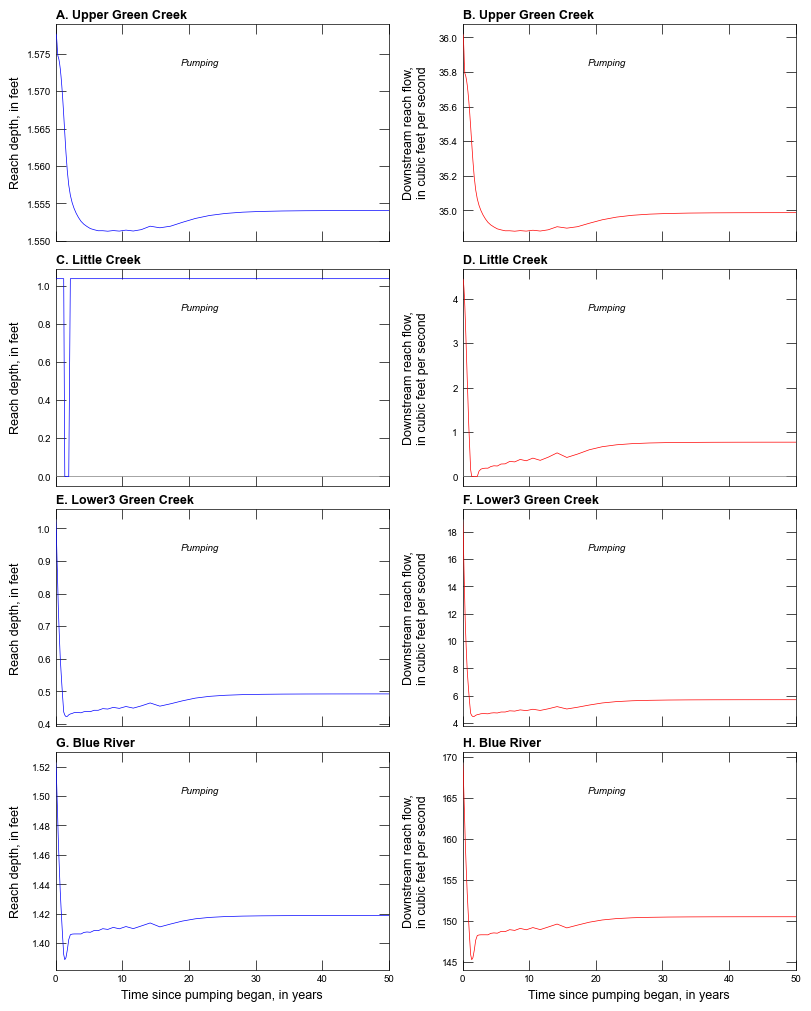

In [19]:
gv.plot_sfr_results(gwf)

We could also go into the `adjust_pumping_callback()` function, change the `ic_pumping` value, and rerun the model to try to get a smoother profile through time to see what a long term sustainable pumping rate is.

Now we examine the pumping rates for the wells from the binary budget file

In [20]:
conv = 365.25 * 86400.0  # seconds to years
cbc = gwf.output.budget()
wels = cbc.get_data(text="WEL")[1:]
totim = np.array(cbc.times[1:])
times = totim - totim[0] # to get time in terms of when pumping began

In [21]:
pumping = np.array([r["q"][0] for r in wels])

In [22]:
# put this in a pandas dataframe, becasue something weird was going on with notebooks
df = pd.DataFrame(
    data=np.array([times, pumping]).T, columns=["time", "pumping"]
)
df["time"] /= conv
df.head()

,time,pumping
0,0.000000,-10.0
1,0.047255,-10.0
2,0.099235,-10.0
3,0.156413,-10.0
4,0.219308,-10.0


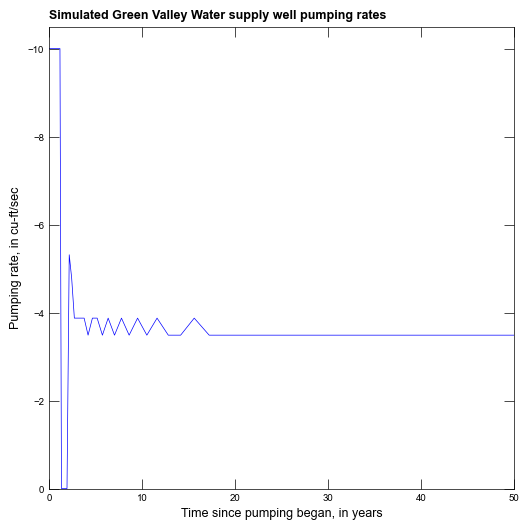

In [23]:
with styles.USGSPlot():
    fig, ax = plt.subplots(figsize=(6, 6))    
    ax.set_xlim(0, 50)
    ax.set_ylim(0, -10.5)
    ax.plot(df.time.values, df.pumping.values, lw=0.5, color="blue")
    ax.set_ylabel("Pumping rate, in cu-ft/sec")
    ax.set_xlabel("Time since pumping began, in years")
    styles.heading(ax, heading="Simulated Green Valley Water supply well pumping rates")
    plt.show()

**If you're intererested in learning more about working with the `modflowapi` python package, example notebooks can be found [here](https://github.com/MODFLOW-USGS/modflowapi/tree/develop/examples/notebooks)**